### classify_insect_std_20200806

In [1]:
import h5py
import imgaug.augmenters as iaa
import numpy as np
from os import getcwd as cwd
from os.path import join as pj
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
%matplotlib inline

# evaluation
from evaluation.classification.statistics import get_size_list_from_xte

In [2]:
def get_insect_size_dic(X, Y, lbl_to_name):
    """
        get dictionary of label to size
        Args:
            - X: np.array, shape==[insect_num, height, width, channels]
            - Y: np.array, shape==[insect_num]
            - lbl_to_name: dict, {label: label_name}
    """
    X_size = np.array(get_size_list_from_xte(X))
    insect_size_dic = {}
    for i in range(len(lbl_to_name)):
        insect_filter = Y == i
        filtered_X_size = X_size[insect_filter]
        filtered_X_size = np.sort(filtered_X_size)
        insect_size_dic.update({lbl_to_name[i]: filtered_X_size})
    return insect_size_dic

def gaussian(mu, sigma):
    """
        return gaussian distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    def f(x):
        return np.exp(-0.5 * (x - mu) ** 2 / sigma) / np.sqrt(2 * np.pi * sigma)
    return f

def laplace(mu, sigma):
    """
        return laplace distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    b = np.sqrt(sigma / 2)
    def f(x):
        return 1 / (2 * b) * np.exp(-1 * np.abs(x - mu) / b)
    return f

In [3]:
lbl_to_name = {
    0: 'Diptera', 
    1: 'Ephemeridae', 
    2: 'Ephemeroptera', 
    3: 'Lepidoptera', 
    4: 'Plecoptera', 
    5: 'Trichoptera', 
}

In [4]:
all_data_path = pj(cwd(), "data/all_classification_data/classify_insect_std_20200806")
with h5py.File(all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
    
aug = iaa.CropAndPad(
    px=(-30, 30),
    sample_independently=False
)

X_uniform = []
for X_elem in X:
    X_uniform.append(aug(image=X_elem.astype("uint8")))
X_uniform = np.array(X_uniform)

In [5]:
insect_size_dic = get_insect_size_dic(X, Y, lbl_to_name)
insect_size_dic_uniform = get_insect_size_dic(X_uniform, Y, lbl_to_name)

In [6]:
def calc_mu_sigma(insect_size_dic):
    """
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
    """
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu = []
    sigma = []
    for key, value in insect_size_dic.items():
        x = np.log2(insect_size_dic[key])
        gmm.fit(x.reshape(-1, 1))
        mu.append(gmm.means_.reshape([-1])[0])
        sigma.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu), np.array(sigma)

def plot_hist_and_distribution(x, seq, mu, sigma, label_name, x_uniform=None, mu_uniform=None, sigma_uniform=None):
    """
        plot histgram and gaussian distribution
        Args:
            - x: np.array(dtype=float)
            - seq: np.array(dtype=float)
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - label_name: str
            - x_uniform: np.array(dtype=float)
            - mu_uniform: np.array(dtype=float), shape == [class_num]
            - sigma_uniform: np.array(dtype=float), shape == [class_num]
    """
    if x_uniform is not None and mu_uniform is not None and sigma_uniform is not None:
        fig, axe = plt.subplots(1, 2, figsize=(10, 5))
        axe[0].hist(x, bins=100, density=True)
        axe[0].plot(seq, gaussian(mu, sigma)(seq), linewidth=2, color="red")
        axe[0].set_title(label_name + " (default)")
        axe[1].hist(x_uniform, bins=100, density=True)
        axe[1].plot(seq, gaussian(mu_uniform, sigma_uniform)(seq), linewidth=2, color="red")
        axe[1].set_title(label_name + " (random resize)")
    else:
        plt.hist(x, bins=100, density=True)
        plt.plot(seq, gaussian(mu, sigma)(seq), linewidth=2, color="red")
        plt.title(label_name)

In [7]:
mu, sigma = calc_mu_sigma(insect_size_dic)
mu_uniform, sigma_uniform = calc_mu_sigma(insect_size_dic_uniform)
gauss_df = pd.DataFrame({"mu": mu, "mu_uniform": mu_uniform, "sigma": sigma, "sigma_uniform": sigma_uniform})
gauss_df.index = ["Diptera", "Ephemeridae", "Ephemeroptera", "Lepidoptera", "Plecoptera", "Trichoptera"]
gauss_df

,mu,mu_uniform,sigma,sigma_uniform
Diptera,11.621745,11.726481,1.718193,1.766784
Ephemeridae,13.156389,13.177655,0.610698,0.751041
Ephemeroptera,10.989065,11.049361,1.237533,1.315123
Lepidoptera,12.680851,12.746827,1.280974,1.313813
Plecoptera,11.382435,11.475578,0.804964,0.952674
Trichoptera,11.672449,11.733930,0.827905,0.962918


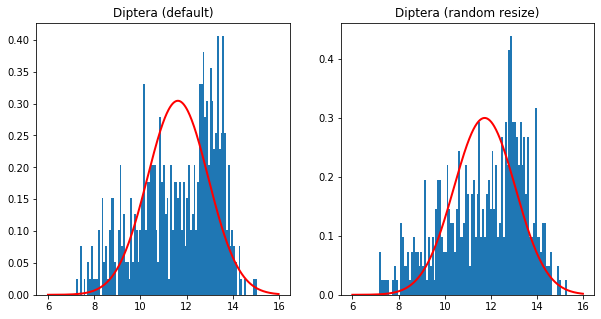

In [8]:
x = np.log2(insect_size_dic["Diptera"])
x_uniform = np.log2(insect_size_dic_uniform["Diptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[0], sigma[0], "Diptera", x_uniform, mu_uniform[0], sigma_uniform[0])

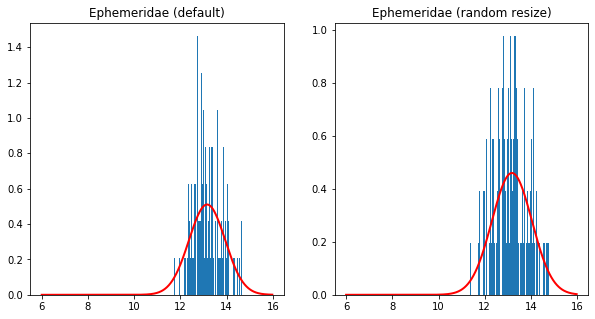

In [9]:
x = np.log2(insect_size_dic["Ephemeridae"])
x_uniform = np.log2(insect_size_dic_uniform["Ephemeridae"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[1], sigma[1], "Ephemeridae", x_uniform, mu_uniform[1], sigma_uniform[1])

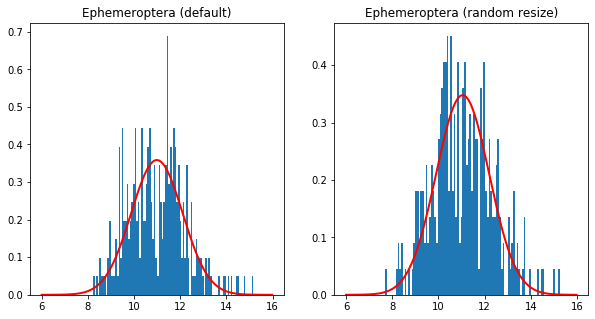

In [10]:
x = np.log2(insect_size_dic["Ephemeroptera"])
x_uniform = np.log2(insect_size_dic_uniform["Ephemeroptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[2], sigma[2], "Ephemeroptera", x_uniform, mu_uniform[2], sigma_uniform[2])

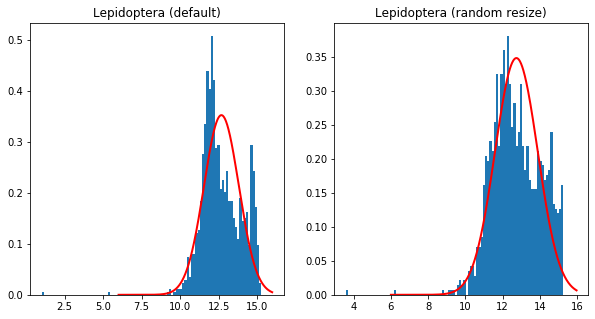

In [11]:
x = np.log2(insect_size_dic["Lepidoptera"])
x_uniform = np.log2(insect_size_dic_uniform["Lepidoptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[3], sigma[3], "Lepidoptera", x_uniform, mu_uniform[3], sigma_uniform[3])

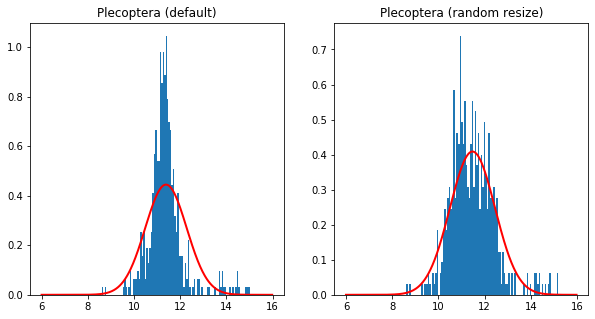

In [12]:
x = np.log2(insect_size_dic["Plecoptera"])
x_uniform = np.log2(insect_size_dic_uniform["Plecoptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[4], sigma[4], "Plecoptera", x_uniform, mu_uniform[4], sigma_uniform[4])

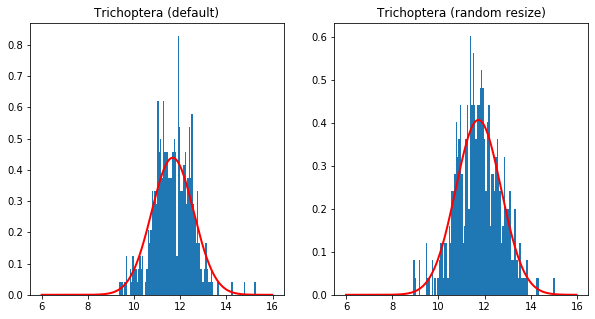

In [13]:
x = np.log2(insect_size_dic["Trichoptera"])
x_uniform = np.log2(insect_size_dic_uniform["Trichoptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[5], sigma[5], "Trichoptera", x_uniform, mu_uniform[5], sigma_uniform[5])

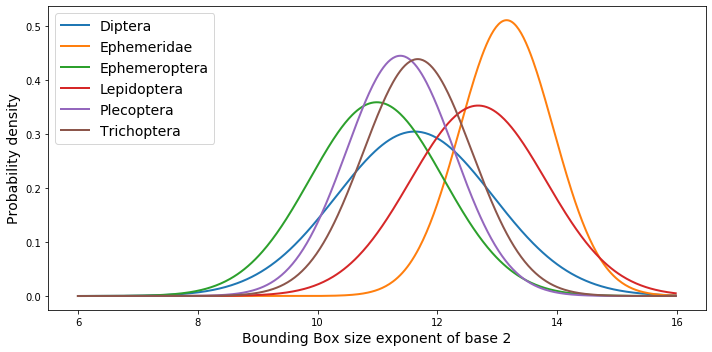

In [14]:
plt.figure(figsize=(10,5))
plt.plot(seq, gaussian(mu[0], sigma[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu[1], sigma[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu[2], sigma[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu[3], sigma[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu[4], sigma[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu[5], sigma[5])(seq), linewidth=2, label="Trichoptera")
plt.xlabel("Bounding Box size exponent of base 2", fontsize=14)
plt.ylabel("Probability density", fontsize=14)
plt.tight_layout()
plt.legend(fontsize=14)
plt.savefig(pj(cwd(), "result/classification/dataset_distributions", "size_distribution.png"))

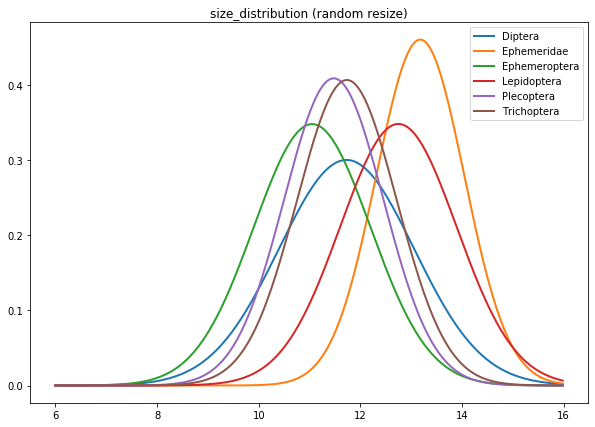

In [15]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu_uniform[0], sigma_uniform[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_uniform[1], sigma_uniform[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_uniform[2], sigma_uniform[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_uniform[3], sigma_uniform[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_uniform[4], sigma_uniform[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_uniform[5], sigma_uniform[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution (random resize)")
plt.legend()

### (1) normalize and sift mu

In [16]:
def normalize_and_sift_mu(insect_size_dic, mu, sigma, lbl_to_name):
    """
        keep mu and match sigma = 1
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - lbl_to_name: dict, {label: label_name}
    """
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu_converted = []
    sigma_converted = []
    for key, value in lbl_to_name.items():
        x = np.log2(insect_size_dic[value])
        x_convert = (x - mu[key]) / sigma[key]
        x_convert += mu[key]
        gmm.fit(x_convert.reshape(-1, 1))
        mu_converted.append(gmm.means_.reshape([-1])[0])
        sigma_converted.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu_converted), np.array(sigma_converted)

In [17]:
mu_converted, sigma_converted = normalize_and_sift_mu(insect_size_dic, mu, sigma, lbl_to_name)
for key, value in lbl_to_name.items():
    print("name = {}: mu = {}, sigma = {}".format(value, mu_converted[key], sigma_converted[key]))

name = Diptera: mu = 11.621745343986495, sigma = 1.000000330633913
name = Ephemeridae: mu = 13.156389134540904, sigma = 0.9999991593446854
name = Ephemeroptera: mu = 10.989064618392351, sigma = 1.0000001735198443
name = Lepidoptera: mu = 12.68085061426625, sigma = 1.0000001952882762
name = Plecoptera: mu = 11.38243516582298, sigma = 0.9999997283549432
name = Trichoptera: mu = 11.672449439591857, sigma = 0.9999997705277541


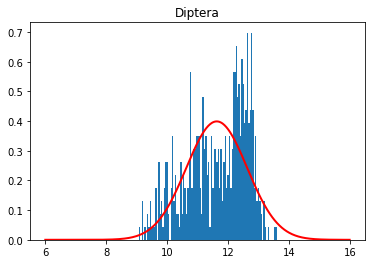

In [18]:
x = np.log2(insect_size_dic["Diptera"])
x_convert = (x - mu[0]) / sigma[0]
x_convert += mu[0]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[0], sigma_converted[0], "Diptera")

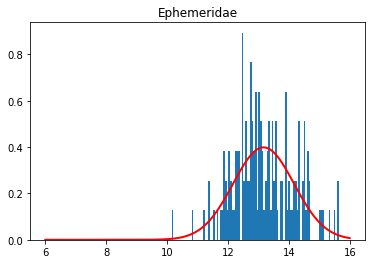

In [19]:
x = np.log2(insect_size_dic["Ephemeridae"])
x_convert = (x - mu[1]) / sigma[1]
x_convert += mu[1]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[1], sigma_converted[1], "Ephemeridae")

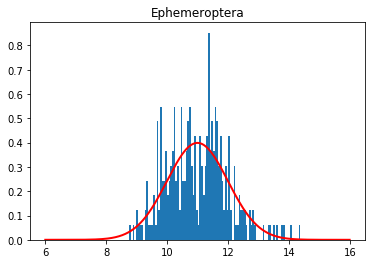

In [20]:
x = np.log2(insect_size_dic["Ephemeroptera"])
x_convert = (x - mu[2]) / sigma[2]
x_convert += mu[2]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[2], sigma_converted[2], "Ephemeroptera")

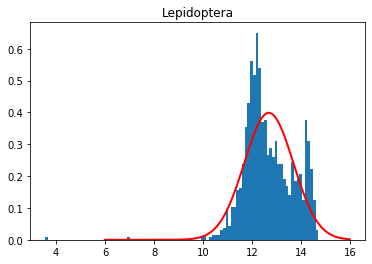

In [21]:
x = np.log2(insect_size_dic["Lepidoptera"])
x_convert = (x - mu[3]) / sigma[3]
x_convert += mu[3]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[3], sigma_converted[3], "Lepidoptera")

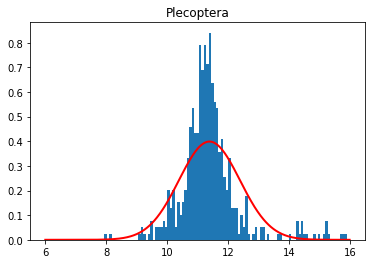

In [22]:
x = np.log2(insect_size_dic["Plecoptera"])
x_convert = (x - mu[4]) / sigma[4]
x_convert += mu[4]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[4], sigma_converted[4], "Plecoptera")

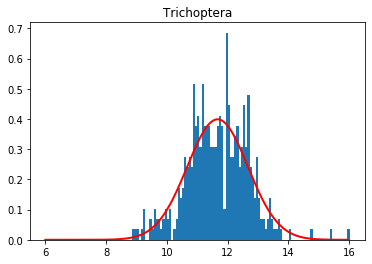

In [23]:
x = np.log2(insect_size_dic["Trichoptera"])
x_convert = (x - mu[5]) / sigma[5]
x_convert += mu[5]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[5], sigma_converted[5], "Trichoptera")

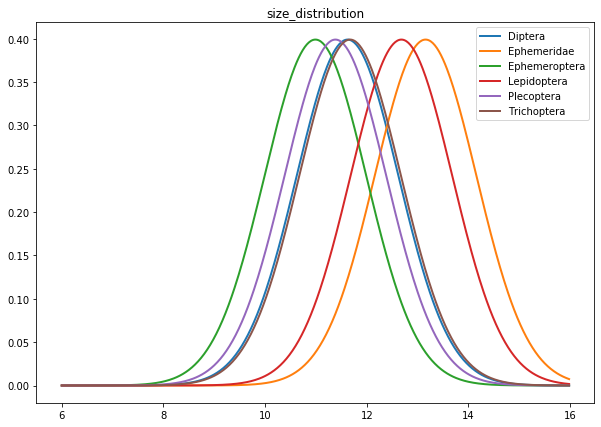

In [24]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu_converted[0], sigma_converted[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_converted[1], sigma_converted[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_converted[2], sigma_converted[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_converted[3], sigma_converted[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_converted[4], sigma_converted[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_converted[5], sigma_converted[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution")
plt.legend()

### (2) average and match mu

In [25]:
def average_and_match_mu(insect_size_dic, mu, sigma, lbl_to_name, keep_sigma=False):
    """
        match mu to average
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - lbl_to_name: dict, {label: label_name}
            - keep_sigma: bool
    """
    mu_average = mu.mean()
    
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu_converted = []
    sigma_converted = []
    for key, value in lbl_to_name.items():
        x = np.log2(insect_size_dic[value])
        if keep_sigma is True:
            x_convert = x + (mu_average - mu[key])
        else:
            x_convert = (x - mu[key]) / sigma[key]
            x_convert += mu_average
        gmm.fit(x_convert.reshape(-1, 1))
        mu_converted.append(gmm.means_.reshape([-1])[0])
        sigma_converted.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu_converted), np.array(sigma_converted)

- sigma = 1

In [26]:
mu_converted, sigma_converted = average_and_match_mu(insect_size_dic, mu, sigma, lbl_to_name, keep_sigma=False)
for key, value in lbl_to_name.items():
    print("name = {}: mu = {}, sigma = {}".format(value, mu_converted[key], sigma_converted[key]))

name = Diptera: mu = 11.917155719433476, sigma = 1.0000003306338987
name = Ephemeridae: mu = 11.917155719433474, sigma = 0.999999159344657
name = Ephemeroptera: mu = 11.917155719433474, sigma = 1.0000001735198656
name = Lepidoptera: mu = 11.917155719433476, sigma = 1.0000001952882904
name = Plecoptera: mu = 11.917155719433476, sigma = 0.9999997283549716
name = Trichoptera: mu = 11.917155719433472, sigma = 0.9999997705277399


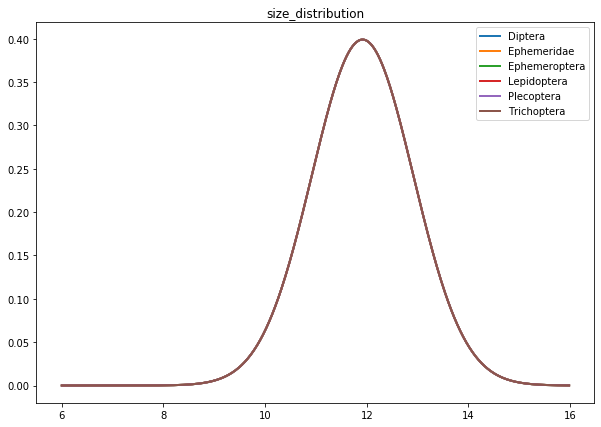

In [27]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu_converted[0], sigma_converted[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_converted[1], sigma_converted[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_converted[2], sigma_converted[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_converted[3], sigma_converted[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_converted[4], sigma_converted[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_converted[5], sigma_converted[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution")
plt.legend()

- sigma = keep

In [28]:
mu_converted, sigma_converted = average_and_match_mu(insect_size_dic, mu, sigma, lbl_to_name, keep_sigma=True)
for key, value in lbl_to_name.items():
    print("name = {}: mu = {}, sigma = {}".format(value, mu_converted[key], sigma_converted[key]))

name = Diptera: mu = 11.917155719433476, sigma = 1.7181926510995689
name = Ephemeridae: mu = 11.917155719433474, sigma = 0.6106979826352166
name = Ephemeroptera: mu = 11.917155719433474, sigma = 1.237532505380425
name = Lepidoptera: mu = 11.917155719433476, sigma = 1.2809743800315292
name = Plecoptera: mu = 11.917155719433476, sigma = 0.804963562079924
name = Trichoptera: mu = 11.917155719433472, sigma = 0.8279052362708523


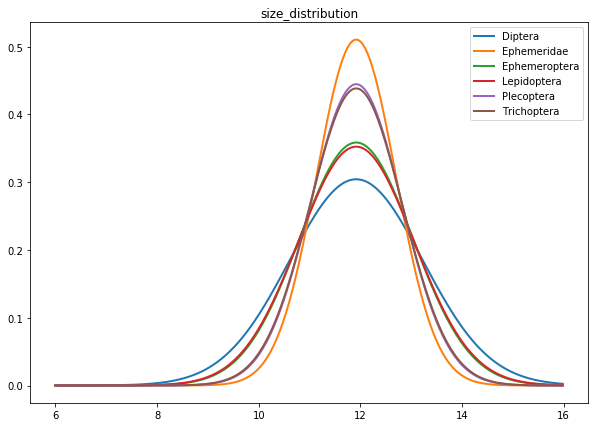

In [29]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu_converted[0], sigma_converted[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_converted[1], sigma_converted[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_converted[2], sigma_converted[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_converted[3], sigma_converted[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_converted[4], sigma_converted[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_converted[5], sigma_converted[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution")
plt.legend()